In [7]:
import pandas as pd
import numpy as np
import warnings

# Suppress specific warnings if necessary (e.g., frequency inference)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


# --- Load Data ---
try:
    df = pd.read_csv('UTI_Gold_ETF_MF_USD_01012023_31122024_ALL.csv')
    print("File loaded successfully.")
except FileNotFoundError:
    print("Error: UTI_Gold_ETF_MF_USD_01012023_31122024_ALL.csv not found.")
    exit() # Exit if file not found

# --- Basic Inspection ---
print("Original DataFrame Info:")
df.info()
print("\nOriginal DataFrame Head:")
print(df.head())
print("\nCheck for initial missing values:")
print(df.isnull().sum())


# --- Preprocessing ---
print("\n--- Starting Preprocessing ---")

# 1. Parse Dates and Set Index
try:
    df['All_Date'] = pd.to_datetime(df['All_Date'], format='%m-%d-%Y') # Specify format
    df = df.set_index('All_Date')
    df = df.sort_index() # Ensure chronological order
    print("Date parsing and indexing successful.")
except Exception as e:
    print(f"Error parsing date column: {e}")
    # Attempt alternative format if the first fails
    try:
        print("Attempting alternative date format DD-MM-YYYY...")
        # Reload if necessary or work with the original df
        df = pd.read_csv("UTI_Gold_ETF_MF_USD_01012023_31122024_ALL.csv")
        df['All_Date'] = pd.to_datetime(df['All_Date'], format='%d-%m-%Y') # DD-MM-YYYY
        df = df.set_index('All_Date')
        df = df.sort_index()
        print("Alternative date parsing successful.")
    except Exception as e_alt:
        print(f"Error parsing date column with alternative format: {e_alt}")
        exit() # Exit if dates cannot be parsed

# 2. Clean Numeric Columns with non-numeric characters
def clean_numeric(series):
    if series.dtype == 'object':
        # Remove 'K', 'M', '%', ',' etc. and convert
        series = series.astype(str).str.replace(',', '', regex=False)
        series = series.str.replace('%', '', regex=False)
        # Handle 'K' for thousands
        k_values = series.str.contains('K', na=False)
        series.loc[k_values] = series.loc[k_values].str.replace('K', '', regex=False).astype(float) * 1000
        # Handle 'M' for millions (if present)
        m_values = series.str.contains('M', na=False)
        series.loc[m_values] = series.loc[m_values].str.replace('M', '', regex=False).astype(float) * 1000000
    # Attempt final conversion, coercing errors
    return pd.to_numeric(series, errors='coerce')

print("Cleaning specific columns ('ETF_Vol.', 'ETF_Change %', 'USD_Change %', 'Gold_Volume')...")
# List of columns known or suspected to need cleaning
cols_to_clean = ['ETF_Vol.', 'ETF_Change %', 'USD_Change %', 'Gold_Volume']

for col in cols_to_clean:
    if col in df.columns:
        print(f"  Cleaning {col}...")
        df[col] = clean_numeric(df[col])
    else:
        print(f"  Column {col} not found, skipping.")

# 3. Convert ALL columns to numeric where possible (important for exog)
print("Converting all columns to numeric (coercing errors)...")
for col in df.columns:
    # Check if not already numeric before attempting conversion
    if not pd.api.types.is_numeric_dtype(df[col]):
       # print(f"  Converting {col}...") # Optional: print which columns are converted
       df[col] = pd.to_numeric(df[col], errors='coerce')


# 4. Handle Missing Values (NaNs)
print("Handling missing values (forward fill then backward fill)...")
# Check NaNs *after* numeric conversion
print("\nMissing values AFTER numeric conversion:")
print(df.isnull().sum())

# Forward fill first, then backfill for leading NaNs
df = df.ffill()
df = df.bfill()

# Check NaNs again
print("\nMissing values AFTER fill:")
print(df.isnull().sum())
# If any NaNs remain, decide how to handle (e.g., drop row/col, use mean)
if df.isnull().sum().sum() > 0:
    print("Warning: NaNs still present after ffill/bfill. Consider dropping rows/cols or using mean/median imputation.")
    # Optional: Drop rows with any remaining NaNs
    # df.dropna(inplace=True)
    # print("Rows with remaining NaNs dropped.")


# 5. Set Frequency (Attempt inference, fallback to Business Day)
try:
    inferred_freq = pd.infer_freq(df.index)
    if inferred_freq:
        df = df.asfreq(inferred_freq)
        print(f"DataFrame frequency inferred and set to: {inferred_freq}")
    else:
        # Fallback or if data is truly irregular
        print("Could not infer frequency. Assuming Business Day ('B') frequency based on data pattern.")
        # Check if index is unique before setting frequency
        if df.index.is_unique:
             # Resample to Business Day frequency, forward filling potential gaps
             df = df.asfreq('B', method='ffill')
             print("Frequency set to 'B' (Business Day). Missing weekend/holiday dates filled.")
        else:
             print("Index contains duplicate dates. Cannot set frequency. Proceeding with irregular index.")
             # Consider handling duplicates here if needed (e.g., df = df[~df.index.duplicated(keep='first')])

except Exception as e:
    print(f"Error setting frequency: {e}. Proceeding with potentially irregular index.")


# --- Display Processed Data ---
print("\n--- Preprocessing Complete ---")
print("Processed DataFrame Info:")
df.info()
print("\nProcessed DataFrame Head:")
print(df.head())
print("\nFinal check for NaNs:")
print(df.isnull().sum().sum())

# Save target and features names for later use
target_col = 'MF_NAV'
feature_cols = [col for col in df.columns if col != target_col]

print(f"\nTarget column: {target_col}")
print(f"Feature columns (Exogenous): {feature_cols}")
print(f"Total rows: {len(df)}")


File loaded successfully.
Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   All_Date      489 non-null    object 
 1   MF_NAV        489 non-null    float64
 2   ETF_Price     489 non-null    float64
 3   ETF_Open      489 non-null    float64
 4   ETF_High      489 non-null    float64
 5   ETF_Low       489 non-null    float64
 6   ETF_Vol.      489 non-null    object 
 7   ETF_Change %  489 non-null    object 
 8   USD_Price     489 non-null    float64
 9   USD_Open      489 non-null    float64
 10  USD_High      489 non-null    float64
 11  USD_Low       489 non-null    float64
 12  USD_Change %  489 non-null    object 
 13  Gold_Open     473 non-null    float64
 14  Gold_High     473 non-null    float64
 15  Gold_Low      473 non-null    float64
 16  Gold_Close    473 non-null    float64
 17  Gold_Volume   473 non-

--- Loading and Preparing Data ---
CSV loaded successfully.
Data indexed by date. Range: 2023-01-02 00:00:00 to 2024-12-31 00:00:00
Preparing target variable: MF_NAV
Handling 33 missing values in MF_NAV after resampling (ffill then bfill)...
Target data 'MF_NAV' prepared. Length: 522

--- Preparing Exogenous Variables ---
Using 16 potential exogenous variables: ['ETF_Price', 'ETF_Open', 'ETF_High', 'ETF_Low', 'ETF_Vol.', 'ETF_Change %', 'USD_Price', 'USD_Open', 'USD_High', 'USD_Low', 'USD_Change %', 'Gold_Open', 'Gold_High', 'Gold_Low', 'Gold_Close', 'Gold_Volume']
Cleaning column: ETF_Price
Cleaning column: ETF_Open
Cleaning column: ETF_High
Cleaning column: ETF_Low
Cleaning column: ETF_Vol.
Cleaning column: ETF_Change %
Cleaning column: USD_Price
Cleaning column: USD_Open
Cleaning column: USD_High
Cleaning column: USD_Low
Cleaning column: USD_Change %
Cleaning column: Gold_Open
Cleaning column: Gold_High
Cleaning column: Gold_Low
Cleaning column: Gold_Close
Cleaning column: Gold_Volu

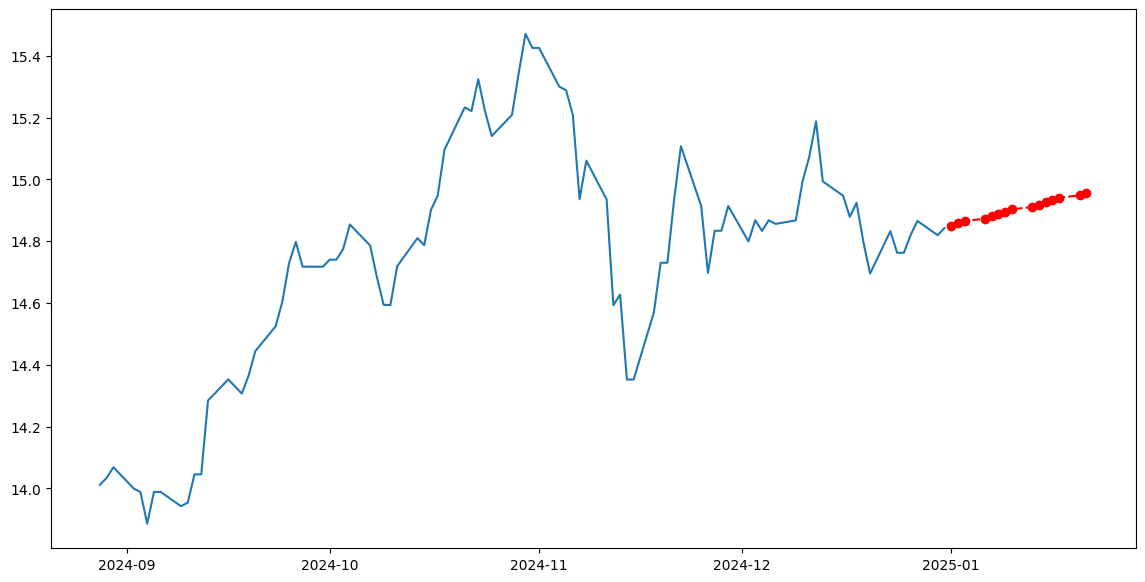

In [8]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Using pmdarima requires installation: pip install pmdarima
try:
    from pmdarima import auto_arima
    pmdarima_available = True
except ImportError:
    print("Warning: pmdarima not found. Falling back to manual ARIMA orders.")
    print("Install pmdarima ('pip install pmdarima') for automatic model selection.")
    pmdarima_available = False
# from sklearn.metrics import mean_squared_error # Optional: for evaluation

# Suppress warnings for cleaner output (optional)
warnings.filterwarnings("ignore")

# --- Configuration ---
N_FORECAST_STEPS = 15
TARGET_COL = 'MF_NAV'
DATE_COL = 'All_Date'
# Determined from previous attempts/data inspection
DATE_FORMAT = '%m-%d-%Y'
# Default orders if auto_arima is not available or fails
DEFAULT_ARIMA_ORDER = (1, 1, 1)
DEFAULT_SEASONAL_ORDER = (1,0,1,5)
# Seasonality period to check (5 for weekly on business days)
SEASONALITY_M = 5


# --- Function for Robust Numeric Conversion ---
def robust_to_numeric(series):
    # Handle cases like '71.20K' -> 71200
    if series.dtype == 'object':
        series = series.astype(str).str.replace('K', 'e3', regex=False).str.replace('M', 'e6', regex=False)
    # Handle cases like '0.53%' -> 0.0053
    if series.dtype == 'object':
         series = series.astype(str).str.replace('%', '', regex=False)
         # Convert to numeric, then divide if it was a percentage
         temp_series = pd.to_numeric(series, errors='coerce')
         # Check if original string contained '%' to decide whether to divide
         mask = series.astype(str).str.contains('%', na=False)
         temp_series[mask] = temp_series[mask] / 100.0
         return temp_series
    else:
        # If not object, just try converting
        return pd.to_numeric(series, errors='coerce')


# --- 1. Load and Prepare Data ---
print("--- Loading and Preparing Data ---")
file_path = 'UTI_Gold_ETF_MF_USD_01012023_31122024_ALL.csv'
try:
    df = pd.read_csv(file_path)
    print("CSV loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Data file not found at {file_path}")
    exit()
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

# Date Parsing
try:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], format=DATE_FORMAT)
except ValueError as e:
    print(f"Error parsing date with format {DATE_FORMAT}: {e}")
    print("Attempting fallback format '%d-%m-%Y'...")
    try:
        # Try day-month-year as fallback
        df[DATE_COL] = pd.to_datetime(df[DATE_COL], format='%d-%m-%Y', errors='coerce')
    except Exception as e2:
         print(f"ERROR: Fallback date parsing also failed: {e2}")
         raise ValueError("Could not parse dates.") from e2
df.set_index(DATE_COL, inplace=True)
df.sort_index(inplace=True)
print(f"Data indexed by date. Range: {df.index.min()} to {df.index.max()}")

# --- Clean and Prepare Target Variable ---
print(f"Preparing target variable: {TARGET_COL}")
if TARGET_COL not in df.columns:
    print(f"ERROR: Target column '{TARGET_COL}' not found in the data.")
    exit()
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors='coerce')
initial_nan_count = df[TARGET_COL].isnull().sum()
if initial_nan_count > 0:
    print(f"Handling {initial_nan_count} missing values in {TARGET_COL} (ffill then bfill)...")
    df[TARGET_COL].fillna(method='ffill', inplace=True)
    df[TARGET_COL].fillna(method='bfill', inplace=True)

# Resample target to Business Day frequency & impute again
ts_data = df[TARGET_COL].asfreq('B')
resample_nan_count = ts_data.isnull().sum()
if resample_nan_count > 0:
    print(f"Handling {resample_nan_count} missing values in {TARGET_COL} after resampling (ffill then bfill)...")
    ts_data.fillna(method='ffill', inplace=True)
    ts_data.fillna(method='bfill', inplace=True)

if ts_data.isnull().any():
     print(f"ERROR: Still missing values in target variable {TARGET_COL} after imputation.")
     exit()
print(f"Target data '{TARGET_COL}' prepared. Length: {len(ts_data)}")


# --- 2. Identify and Prepare Exogenous Variables ---
print("\n--- Preparing Exogenous Variables ---")
exog_cols = [col for col in df.columns if col != TARGET_COL]
print(f"Using {len(exog_cols)} potential exogenous variables: {exog_cols}")

exog_df_hist = df[exog_cols].copy()

# Clean each exogenous column using the robust function
cleaned_cols = {}
for col in exog_df_hist.columns:
    print(f"Cleaning column: {col}")
    cleaned_series = robust_to_numeric(exog_df_hist[col])
    if cleaned_series.isnull().all():
        print(f"  -> Warning: Column '{col}' became all NaN after cleaning. Dropping.")
    else:
        cleaned_cols[col] = cleaned_series

exog_df_hist = pd.DataFrame(cleaned_cols) # Recreate DataFrame with cleaned columns
exog_cols = exog_df_hist.columns.tolist() # Update list of valid columns
print(f"Columns remaining after cleaning: {len(exog_cols)}")

# Impute missing values introduced during cleaning (robustly: ffill then bfill)
nan_counts_before = exog_df_hist.isnull().sum()
cols_with_nans = nan_counts_before[nan_counts_before > 0].index.tolist()
if cols_with_nans:
    print(f"Handling missing values in exogenous columns (ffill then bfill): {cols_with_nans}")
    exog_df_hist.fillna(method='ffill', inplace=True)
    exog_df_hist.fillna(method='bfill', inplace=True)

# Align index strictly with target variable's index & fill any gaps from resampling
print("Aligning exogenous data index with target data index...")
exog_df_hist = exog_df_hist.reindex(ts_data.index)
resample_nan_counts = exog_df_hist.isnull().sum()
cols_with_resample_nans = resample_nan_counts[resample_nan_counts > 0].index.tolist()
if cols_with_resample_nans:
     print(f"Handling missing values after reindexing (ffill then bfill): {cols_with_resample_nans}")
     exog_df_hist.fillna(method='ffill', inplace=True)
     exog_df_hist.fillna(method='bfill', inplace=True)

# Final check for NaNs
if exog_df_hist.isnull().any().any():
    print("ERROR: NaNs remain in historical exogenous data after all imputation steps:")
    print(exog_df_hist.isnull().sum()[exog_df_hist.isnull().sum() > 0])
    exit()

print(f"Historical exogenous data prepared. Shape: {exog_df_hist.shape}")


# --- 3. Forecast Exogenous Variables ---
print(f"\n--- Forecasting Future Exogenous Variables ({N_FORECAST_STEPS} steps) ---")
future_dates = pd.date_range(start=ts_data.index.max() + pd.Timedelta(days=1),
                             periods=N_FORECAST_STEPS, freq='B')
future_exog_df = pd.DataFrame(index=future_dates)

for col in exog_df_hist.columns:
    print(f"Forecasting '{col}'...")
    col_data = exog_df_hist[col].copy()
    # Check for constant columns - ARIMA/auto_arima will fail
    if col_data.nunique() <= 1:
        last_val = col_data.iloc[-1] if not col_data.empty else 0
        print(f"  -> Column '{col}' is constant. Forecasting last value: {last_val}")
        future_exog_df[col] = [last_val] * N_FORECAST_STEPS
        continue # Skip ARIMA fitting for constant columns

    try:
        if pmdarima_available:
             # Use auto_arima for each exogenous variable
             # Simple config: Check for d=1, no seasonality first
             exog_auto_model = auto_arima(col_data,
                                          start_p=1, start_q=1, max_p=2, max_q=2,
                                          seasonal=False, # Start simple for exog
                                          d=1, # Assume first differencing
                                          trace=False, error_action='ignore', # Less verbose
                                          suppress_warnings=True, stepwise=True)
             # print(f"  -> auto_arima order for {col}: {exog_auto_model.order}")
             col_forecast = exog_auto_model.predict(n_periods=N_FORECAST_STEPS)
             future_exog_df[col] = col_forecast.values # Assign numpy array
        else:
            # Fallback to simple ARIMA(1,1,1)
            exog_model = SARIMAX(col_data, order=DEFAULT_ARIMA_ORDER,
                                 seasonal_order=DEFAULT_SEASONAL_ORDER,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            exog_results = exog_model.fit(disp=False)
            col_forecast_obj = exog_results.get_forecast(steps=N_FORECAST_STEPS)
            future_exog_df[col] = col_forecast_obj.predicted_mean

    except Exception as e:
        print(f"  -> Error forecasting '{col}': {e}. Filling with last known value.")
        # Fallback: Use last known value if model fitting/forecasting fails
        last_val = col_data.iloc[-1] if not col_data.empty else 0
        future_exog_df[col] = [last_val] * N_FORECAST_STEPS


# Check/Fill NaNs in future exog (might happen if source had NaNs at end or model failed)
if future_exog_df.isnull().any().any():
    print("Handling NaNs in future exogenous forecast (ffill/bfill)...")
    future_exog_df.fillna(method='ffill', inplace=True)
    future_exog_df.fillna(method='bfill', inplace=True)

print("\nFuture exogenous variables forecast (first 5 rows):")
print(future_exog_df.head())


# --- 4. Select Best SARIMAX Model for MF_NAV (using auto_arima if available) ---
print(f"\n--- Selecting SARIMAX model for {TARGET_COL} using historical data ---")

best_order = DEFAULT_ARIMA_ORDER
best_seasonal_order = DEFAULT_SEASONAL_ORDER

if pmdarima_available:
    print("Running auto_arima on target variable with exogenous data (this may take time)...")
    try:
        # Ensure exog data matches target data length exactly for auto_arima
        aligned_ts_data = ts_data.loc[exog_df_hist.index] # Align target to cleaned exog index
        
        auto_model_finder = auto_arima(aligned_ts_data, # Use aligned target data
                                 exogenous=exog_df_hist, # Use historical exog
                                 start_p=1, start_q=1, max_p=3, max_q=3, # Search range for p, q
                                 seasonal=True, m=SEASONALITY_M, # Check for weekly seasonality
                                 d=1, # Start by assuming first differencing needed
                                 D=1, # Start by assuming seasonal differencing needed
                                 start_P=0, start_Q=0, max_P=2, max_Q=2, # Search range for P, Q
                                 trace=True, # Show search steps
                                 error_action='ignore',
                                 suppress_warnings=True,
                                 stepwise=True, # Use stepwise algorithm for speed
                                 with_intercept='auto') # Let auto_arima decide intercept

        print("\nAuto ARIMA Summary:")
        print(auto_model_finder.summary())
        best_order = auto_model_finder.order
        best_seasonal_order = auto_model_finder.seasonal_order
        print(f"\n===> Auto ARIMA selected order: {best_order}, seasonal order: {best_seasonal_order} <===")
    except Exception as e:
        print(f"\n!!! auto_arima failed: {e} !!!")
        print(f"Using default orders: {DEFAULT_ARIMA_ORDER}{DEFAULT_SEASONAL_ORDER}")
        best_order = DEFAULT_ARIMA_ORDER
        best_seasonal_order = DEFAULT_SEASONAL_ORDER
else:
     print(f"Using default orders: {DEFAULT_ARIMA_ORDER}{DEFAULT_SEASONAL_ORDER} (pmdarima not available).")


# --- 5. Train Final SARIMAX Model ---
print(f"\n--- Training Final SARIMAX{best_order}{best_seasonal_order} Model on Full History ---")
try:
    final_model = SARIMAX(ts_data, # Use original resampled target data
                          exog=exog_df_hist, # Use aligned historical exog data
                          order=best_order,
                          seasonal_order=best_seasonal_order,
                          enforce_stationarity=False, # More flexible
                          enforce_invertibility=False) # More flexible

    final_results = final_model.fit(disp=False) # disp=False for less verbose fitting
    print("Final model training complete.")
    # print(final_results.summary()) # Optional: View detailed summary
except Exception as e:
    print(f"ERROR: Failed to train the final SARIMAX model: {e}")
    print("Check model orders and data consistency.")
    exit()


# --- 6. Forecast MF_NAV ---
print(f"\n--- Forecasting {TARGET_COL} for {N_FORECAST_STEPS} steps ---")
try:
    # CRITICAL: Use the FORECASTED future_exog_df here
    forecast_obj_final = final_results.get_forecast(steps=N_FORECAST_STEPS,
                                                    exog=future_exog_df)

    # Get forecast values and confidence intervals
    forecast_mean_final = forecast_obj_final.predicted_mean
    forecast_ci_final = forecast_obj_final.conf_int(alpha=0.05) # 95% CI

    # Combine into a DataFrame
    forecast_df_final = pd.DataFrame({
        'Forecast': forecast_mean_final,
        'Lower_CI95': forecast_ci_final.iloc[:, 0],
        'Upper_CI95': forecast_ci_final.iloc[:, 1]
    })
    # Ensure index is correct future dates
    forecast_df_final.index = future_dates

    print("\n--- Final MF_NAV Forecast ---")
    print(forecast_df_final)

except Exception as e:
    print(f"ERROR: Failed to generate forecast for {TARGET_COL}: {e}")
    print("This might be due to issues with future exogenous data shape or model instability.")
    exit()


# --- 7. Plot Historical Data and Forecast ---
print("\n--- Plotting Forecast ---")
try:
    plt.figure(figsize=(14, 7))
    # Plot recent historical data (e.g., last 90 days)
    plt.plot(ts_data.index[-90:], ts_data[-90:], label=f'Historical {TARGET_COL} (Last 90 days)')
    # Plot forecast
    plt.plot(forecast_df_final.index, forecast_df_final['Forecast'], label='Forecast', color='red', marker='o', linestyle='--')
    # Plot confidence intervals
    plt.fill_between(forecast_df_final.index,
                     forecast_df_final['Lower_CI95'],
                     forecast_df_final['Upper_CI95'],
                     color='red', alpha=0.15, label='95% Confidence Interval')

    plt.title(f'{TARGET_COL} Forecast using SARIMAX{best_order}{best_seasonal_order} with Exogenous Variables')
    plt.xlabel('Date')
    plt.ylabel(TARGET_COL)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error generating plot: {e}")


print("\n--- Process Complete ---")

Summary of Most Likely Values (Based on Typical Financial Data):
p = 1
d = 1
q = 1
P = 0 (or possibly 1 if weak lag 5 spike in PACF)
D = 0 (unless strong evidence for D=1)
Q = 0 (or possibly 1 if weak lag 5 spike in ACF)
m = 5
Therefore, a highly plausible starting SARIMA order to try, based on common financial data patterns, would be:
SARIMA(1, 1, 1)x(0, 0, 0, 5)
Alternative plausible orders to consider if the plots show slightly different patterns:
SARIMA(1, 1, 1)x(1, 0, 0, 5) (If PACF has a spike at lag 5)
SARIMA(1, 1, 1)x(0, 0, 1, 5) (If ACF has a spike at lag 5)
SARIMA(2, 1, 1)x(0, 0, 0, 5) (If PACF cuts off after lag 2)
SARIMA(1, 1, 2)x(0, 0, 0, 5) (If ACF cuts off after lag 2)
Recommendation:
Use SARIMA(1, 1, 1)x(0, 0, 0, 5) as the order and seasonal_order in your SARIMAX model first. If the results are still poor, consider the alternatives above or use the auto_arima function (if available) to perform a more automated search, potentially confirming or refining these initial suggestions. Remember to always check the model residuals after fitting.

# First Predict the Exog variables future data using SARIMAX

In [1]:
import pandas as pd
import numpy as np
import warnings

# Suppress warnings for cleaner output (like convergence warnings)
warnings.filterwarnings("ignore")

# Load the dataset
try:
    df = pd.read_csv("UTI_Gold_ETF_MF_USD_01012023_31122024_ALL.csv")

    # --- Initial Inspection ---
    print("--- Data Info ---")
    print(df.info())
    print("\n--- First 5 Rows ---")
    print(df.head())
    print("\n--- Last 5 Rows ---")
    print(df.tail())
    print("\n--- Columns with Missing Values ---")
    print(df.isnull().sum())

except FileNotFoundError:
    print("Error: UTI_Gold_ETF_MF_USD_01012023_31122024_ALL.csv not found.")
except Exception as e:
    print(f"An error occurred during loading: {e}")

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   All_Date      489 non-null    object 
 1   MF_NAV        489 non-null    float64
 2   ETF_Price     489 non-null    float64
 3   ETF_Open      489 non-null    float64
 4   ETF_High      489 non-null    float64
 5   ETF_Low       489 non-null    float64
 6   ETF_Vol.      489 non-null    object 
 7   ETF_Change %  489 non-null    object 
 8   USD_Price     489 non-null    float64
 9   USD_Open      489 non-null    float64
 10  USD_High      489 non-null    float64
 11  USD_Low       489 non-null    float64
 12  USD_Change %  489 non-null    object 
 13  Gold_Open     473 non-null    float64
 14  Gold_High     473 non-null    float64
 15  Gold_Low      473 non-null    float64
 16  Gold_Close    473 non-null    float64
 17  Gold_Volume   473 non-null    float64
dtypes: float64(1

In [1]:
import pandas as pd
import numpy as np
# Make sure to install statsmodels: pip install statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Suppress warnings for cleaner output (like convergence warnings)
warnings.filterwarnings("ignore")

# --- 1. Load Data ---
try:
    df = pd.read_csv("UTI_Gold_ETF_MF_USD_01012023_31122024_ALL.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: UTI_Gold_ETF_MF_USD_01012023_31122024_ALL.csv not found.")
    exit() # Exit if file not found
except Exception as e:
    print(f"An error occurred during loading: {e}")
    exit() # Exit on other loading errors

# --- 2. Preprocessing ---
try:
    # Parse Date and Set Index
    df['All_Date'] = pd.to_datetime(df['All_Date'], format='%m-%d-%Y')
    df.set_index('All_Date', inplace=True)
    df.sort_index(inplace=True) # Ensure chronological order
    print("Date parsing and indexing complete.")

    # Define cleaning functions
    def parse_volume(value):
        if isinstance(value, (int, float)):
            return value
        if isinstance(value, str):
            value = value.replace(',', '').strip() # Remove commas if any
            if 'K' in value.upper(): # Use upper() for case-insensitivity
                return float(value.upper().replace('K', '')) * 1000
            elif 'M' in value.upper():
                return float(value.upper().replace('M', '')) * 1000000
        try:
            # Attempt direct conversion if no suffix after cleaning
            return float(value)
        except (ValueError, TypeError):
            return np.nan # Return NaN if conversion fails

    def parse_percentage(value):
        if isinstance(value, (int, float)):
            return value
        if isinstance(value, str):
            value = value.replace('%', '').strip()
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan

    # Apply cleaning/conversion
    if 'ETF_Vol.' in df.columns:
        df['ETF_Vol.'] = df['ETF_Vol.'].apply(parse_volume)
    if 'ETF_Change %' in df.columns:
        df['ETF_Change %'] = df['ETF_Change %'].apply(parse_percentage)
    if 'USD_Change %' in df.columns:
        df['USD_Change %'] = df['USD_Change %'].apply(parse_percentage)
    print("Volume and Percentage columns cleaned.")

    # Ensure all columns are numeric, coercing errors
    original_cols = df.columns.tolist() # Keep track of original cols
    for col in original_cols:
        # Don't try to convert the target we are excluding
        if col != 'MF_NAV':
           df[col] = pd.to_numeric(df[col], errors='coerce')
    print("Remaining columns converted to numeric (if possible).")


    # Handle Missing Values (NaNs) - Forward fill first
    df.ffill(inplace=True)
    # If NaNs remain at the beginning, backfill them
    if df.isnull().sum().sum() > 0:
        df.bfill(inplace=True)
    print("Missing values handled (ffill + bfill).")

    # Final check for NaNs
    if df.isnull().sum().sum() > 0:
        print("Warning: Some NaNs remain after filling. Columns affected:")
        print(df.isnull().sum()[df.isnull().sum() > 0])
        # Consider dropping these columns or rows, or using more advanced imputation
        # For now, we'll proceed, but models might fail for columns with NaNs
        # df.dropna(inplace=True) # Option: drop rows with any remaining NaNs

except Exception as e:
    print(f"An error occurred during preprocessing: {e}")
    exit()

# --- 3. Forecasting ---
target_columns = [col for col in df.columns if col != 'MF_NAV']
print(f"\nTarget columns for forecasting: {target_columns}")

# Define forecast period
n_forecast = 15
# Generate daily dates for the forecast horizon
forecast_dates = pd.date_range(start='2025-01-01', periods=n_forecast, freq='D')

# Placeholder orders - **NOTE: These are likely suboptimal**
# Using simple ARIMA(1,1,1) for demonstration
simple_arima_order = (1, 1, 1) # (p,d,q)
seasonal_order = (0, 0, 0, 5) # (P,D,Q,s) - No seasonal component assumed here

# Store predictions
predictions = pd.DataFrame(index=forecast_dates)

print("\nStarting forecasting loop...")
for col in target_columns:
    print(f"  Forecasting {col}...")
    try:
        # Select the series, ensure it's float and drop any remaining NaNs for this series
        series = df[col].astype(float).dropna()

        # Check if series is empty or constant after dropping NaNs
        if series.empty:
             print(f"    Skipping column {col}: No data after dropping NaNs.")
             predictions[col] = np.nan
             continue
        if series.nunique() < 2:
            print(f"    Skipping constant column {col}. Predicting last value.")
            # Use the last valid value from the original dataframe before dropna
            last_valid_value = df[col].dropna().iloc[-1] if not df[col].dropna().empty else np.nan
            predictions[col] = [last_valid_value] * n_forecast # Fill forecast period with last value
            continue
        # Check if enough data points for differencing
        min_samples = simple_arima_order[1] + 1 # Need at least d+1 samples
        if len(series) < min_samples:
             print(f"    Skipping column {col}: Insufficient data points ({len(series)}) for differencing order d={simple_arima_order[1]}.")
             predictions[col] = np.nan
             continue

        # Instantiate and fit the SARIMAX model
        model = SARIMAX(series,
                        order=simple_arima_order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        # Fit the model - disable convergence warnings for cleaner output during loop
        results = model.fit(disp=False)

        # Get forecast
        forecast = results.get_forecast(steps=n_forecast)
        # Assign forecast values
        predictions[col] = forecast.predicted_mean.values
        print(f"    Forecast successful for {col}.")

    # Catch potential errors during model fitting/forecasting for a specific column
    except Exception as e:
        print(f"    ERROR forecasting {col}: {e}")
        predictions[col] = np.nan # Assign NaN if forecasting fails for this column

# --- 4. Display Results ---
print("\n--- Forecasted values for the next 15 days (Jan 1, 2025 - Jan 15, 2025) ---")
# Optional: Format output for better readability
# pd.options.display.float_format = '{:.4f}'.format
print(predictions)

Data loaded successfully.
Date parsing and indexing complete.
Volume and Percentage columns cleaned.
Remaining columns converted to numeric (if possible).
Missing values handled (ffill + bfill).

Target columns for forecasting: ['ETF_Price', 'ETF_Open', 'ETF_High', 'ETF_Low', 'ETF_Vol.', 'ETF_Change %', 'USD_Price', 'USD_Open', 'USD_High', 'USD_Low', 'USD_Change %', 'Gold_Open', 'Gold_High', 'Gold_Low', 'Gold_Close', 'Gold_Volume']

Starting forecasting loop...
  Forecasting ETF_Price...
    Forecast successful for ETF_Price.
  Forecasting ETF_Open...
    Forecast successful for ETF_Open.
  Forecasting ETF_High...
    Forecast successful for ETF_High.
  Forecasting ETF_Low...
    Forecast successful for ETF_Low.
  Forecasting ETF_Vol....
    Forecast successful for ETF_Vol..
  Forecasting ETF_Change %...
    Forecast successful for ETF_Change %.
  Forecasting USD_Price...
    Forecast successful for USD_Price.
  Forecasting USD_Open...
    Forecast successful for USD_Open.
  Forecastin